In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 1.0       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 10        #number of time-steps to split the total evolution into
L       = 256       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 1         #Batch size, how many independent Universes to simulate

# Notes: Uros uses (n_steps=10, L=512, N=128). Hence, (n_steps=10, L=256, N=64) preserves the resolution/particle density

In [3]:
import flowpm
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import cosmo

@tf.function
def simulation(om, s8):
    cosmo['sigma8'] = tf.convert_to_tensor(s8, dtype=tf.float32)
    cosmo['Omega0_m'] = tf.convert_to_tensor(om, dtype=tf.float32)
    
    stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration
    
    initial_conditions = flowpm.linear_field(N,          # size of the cube
                                             L,          # Physical size of the cube
                                             lambda k: tf.cast(linear_matter_power(cosmo, k), tf.complex64), # Initial powerspectrum
                                             batch_size=batch)

    # Sample particles
    state = flowpm.lpt_init(initial_conditions, a0)   

    # Evolve particles down to z=0
    final_state = flowpm.nbody(state, stages, N)         

    # Retrieve final density field
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
    
    return final_state, final_field

In [4]:
final_state, final_field = simulation(0.3075, 0.8159)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [5]:
print(final_state.shape)
print(final_field.shape)

np.save("final_state", final_state)
np.save("final_field", final_field)

(3, 1, 262144, 3)
(1, 64, 64, 64)


In [6]:
final_state_test = np.load("final_state.npy")
print(final_state_test.shape)

(3, 1, 262144, 3)


In [7]:
print(final_state[:,0,:10,0])

tf.Tensor(
[[-0.41683725 -0.882146   -0.9963332  -0.92176193 -0.7833676  -0.56360316
  -0.2510791   0.19087441  0.9145818   1.248455  ]
 [-0.05230051 -0.28910452 -0.33340383 -0.31432262 -0.23591577 -0.18278444
  -0.17279585  0.04362336  0.46412835  0.6365598 ]
 [ 0.05936937 -0.14744242 -0.19190936 -0.14274962 -0.08211611 -0.08814419
  -0.15830612 -0.01510509  0.41124585  0.55693465]], shape=(3, 10), dtype=float32)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


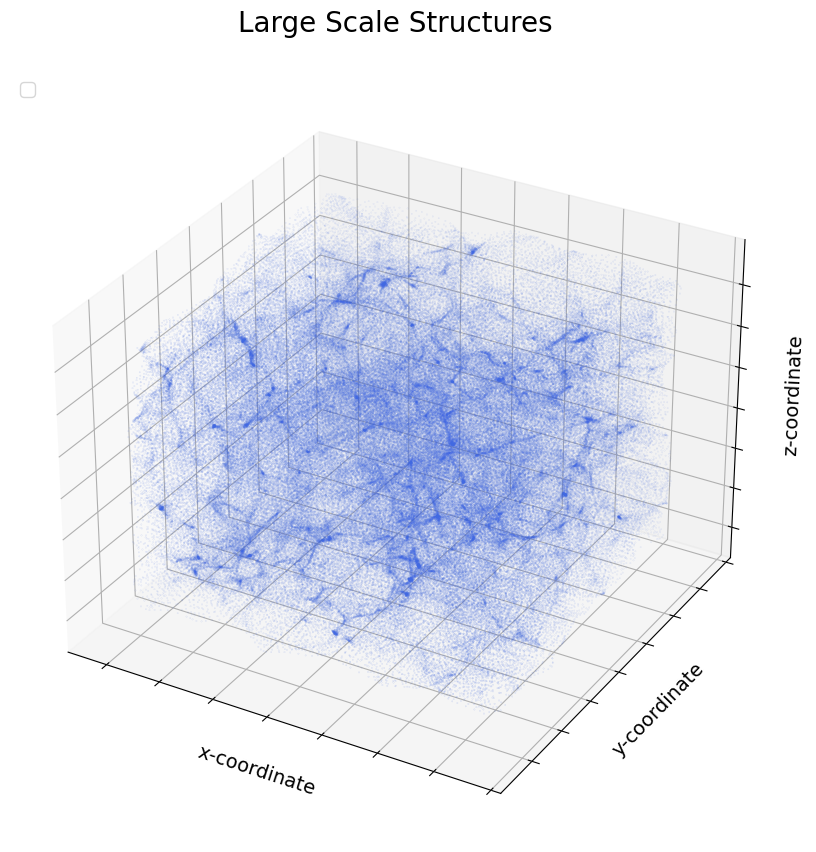

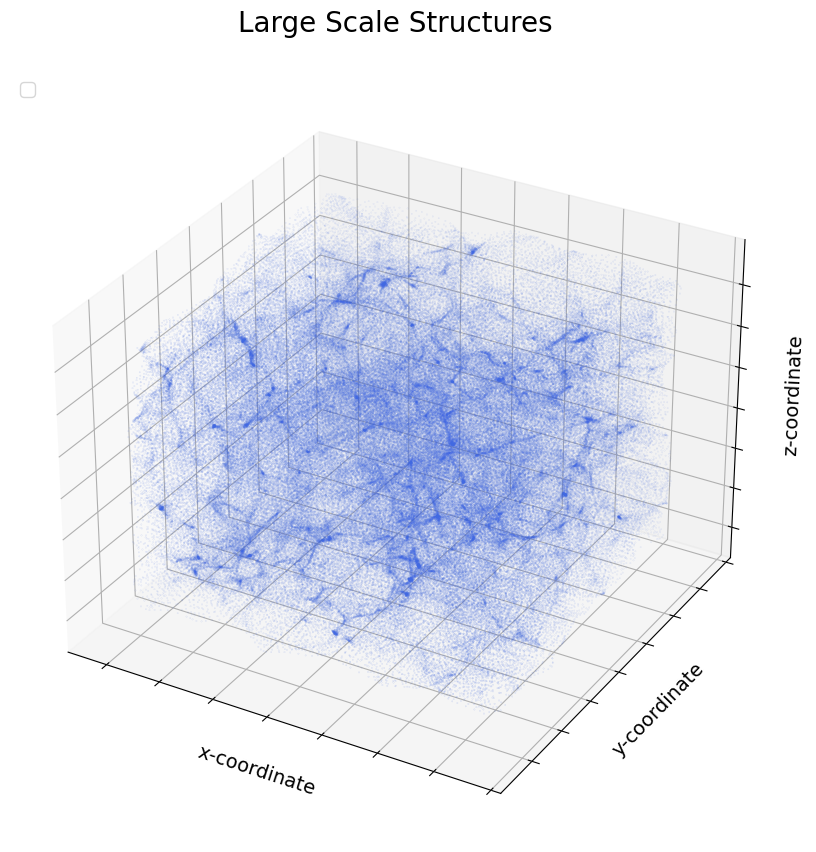

In [10]:
fstate = final_state

fig=plt.figure(figsize=(10,10))#Create 3D axes
ax=fig.add_subplot(111,projection="3d")
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="royalblue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
# plt.savefig('3dfinal.png', dpi=1200)

plt.show()

In [9]:
plt.imshow(final_field[0].numpy().sum(axis=0))

NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.